# Homework 4 - Hard Coding

## Group #12: Vishal Matta, Michele Meo, Giulio Rago

# Hashing Task

### Import data and libraries

In [98]:
import os
import time
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

We import the **hashing_lib** module that contains all the functions used to solve the hashing task:
you can find it in the **utils** folder of the repository.  
It is suggested to read the script every time a function imported from it is used to better understand the code.

In [13]:
from utils import hashing_lib as hs

We import the data in two differents lists, then we delete the last element as it contains an empty string.  
We find out that the passwords to be stored in the filter are 100000000 and the passwords we want  
to compare with the filter, once we stored the first set of passwords, are 39000000.

In [14]:
with open ("/Users/Michele/PycharmProjects/ADM-HW4/DATA/passwords1.txt", "r") as file:
    passwords1 = list(file.read().split("\n"))
    
with open ("/Users/Michele/PycharmProjects/ADM-HW4/DATA/passwords2.txt", "r") as file:
    passwords2 = list(file.read().split("\n"))    

passwords1.pop()
passwords2.pop();

In [15]:
print(len(passwords1))
print(len(passwords2))

100000000
39000000


### Preliminary considerations

Given the false positive rate we are willing to have, $p$, and the number of items that will be stored in filter, $n$,  
the website https://hackernoon.com/probabilistic-data-structures-bloom-filter-5374112a7832  provides us some 
quantitative methods to estimate the needed size of the filter, $m$, and the number of hash functions to be applied, $k$, to have the required $p$.  
In particular, we have chosen to accept a rate of false positives:

\begin{equation}
p = 0.01  -->  p = 1\%.
\end{equation}

Given $n=100000000$, we estimate the size of the filter and the number of needed hash functions with the following formulas:

\begin{equation}
m \approx -{{nlnp}\over{(ln2)^2}}
\end{equation}

\begin{equation}
k \approx {{m}\over{n}}ln2
\end{equation}

as we do in the following code cell.

In [16]:
p = 0.01
n = len(passwords1)
m = int(-(n*math.log(p))/(math.log(2)**2))
k = round((m/n)*math.log(2))
print("We choose a rate of false positives of about", p, ": given the number of passwords " 
      "to be registered in the filter,", n, ", we need at least a filter of size", m, "and", k, 
      "different hash functions.")

We choose a rate of false positives of about 0.01 : given the number of passwords to be registered in the filter, 100000000 , we need at least a filter of size 958505837 and 7 different hash functions.


Given the estimate obtained for the filter size, we choose a size $m$ equal to the first power of 2 higher than such estimate.  
For this choice of size the number of necessary hash functions does not change with respect to the previous estimate and remains $k = 7$; moreover, by choosing a larger size we are more confident about possible collisions.

In [17]:
m = 2**30

### Hash Function discussion

The code for our own hash function is written in the function *hash_function* in the **hashing_lib.py** script.  
Here we describe the concept behind our hash function and, to be clearer, we apply it by hand on a string example '/DXhI;GNl*nbCzKso=?@'.  
Given an index of the string, $i$, the first prime number smaller than $m$, ${prime}_0$, and another prime number near the size of the filter, $prime$, the proposed hash function does (in the example we choose $i=1$):
- takes the i-th-last character of the password and converts it to ascii code, in the example @-->64;
- takes the last character of the ascii number obtained before, in the example 64-->4;
- takes the (10+i)-th-last characters of the passwords, converts them in their ascii code and pick only the last numbers for each ascii number obtained, in the example:   
@-->64-->4; ?-->63-->3; =-->61-->1; o-->111-->1 .......... G-->71-->1;
- joins all the numbers obtained by the previous step in a string and converts this string in an int number:  
43115527802881
- converts the i-th character of the password in its ascii code, in the example /-->47, then apply the following formula to this number and the number obtained the previous step, in the example:
\begin{equation}
(43115527802881\cdot{prime}+47)\;\textrm{mod}({prime}_0)
\end{equation}
and we have our hash value given the password.  

With this method it is possible to obtain different hash functions by changing the $i$ and $prime$ parameters described above: we do it in the *multi_hash_function* in **hashing_lib** module and to evaluate prime numbers near the size of the filter we use the funcion *LastPrimes* in the same module.  
The fact of considering a number of different numbers based on the ascii code of the i-th-last character, allows us to change the order of magnitude of the hash value for each different passowrd.  
Furthermore, always considering only the last number of the ascii conversion allows us to obtain a uniform distribution.

### Testing our Hash Function

Let's create a BloomFilter object of size $m$ (read the script **hashing_lib.py**).

In [18]:
bloom_filter = hs.BloomFilter(m)

To minimize the probability of having collisions, the hash function must generate values uniformly distributed between 0 and the filter size.  
Below, we verify that the values calculated on the first 1000000 passwords are uniformly distributed.

In [88]:
hash_values = bloom_filter.testing_hash_function(passwords1[:1000000])

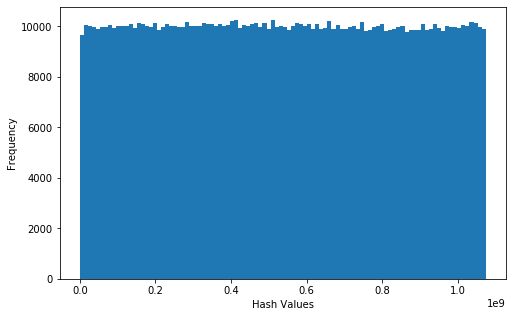

In [95]:
fig = plt.figure(figsize=(8,5))
plt.xlabel("Hash Values")
plt.ylabel("Frequency")
plt.hist(hash_values, bins=100)
plt.show()

### Bloom Filter implementation

We apply 7 different hash functions to the set of passwords1 to store them on our filter, then we apply the same 7 hash functions to the set of passwords2 to verify which of these are already stored in the filter.  
Furthermore, as requested, we calculate the execution time: this could be higher than the one strictly necessary to store passwords1 in the filter and check passwords2 because we also store all the passwords that are duplicated in a list (for a possible bonus task).

In [19]:
start = time.time()

bloom_filter.multi_hash_functions(passwords1, 7)
positives = bloom_filter.hash_searching(passwords2, 7)

end = time.time()

Finally we can save the probable duplicates in a txt file and evaluate the execution time of our algorithm.

In [11]:
with open('duplicates.txt', 'w') as f:
    for item in bloom_filter.duplicates:
        f.write("%s\n" % item)

In [123]:
run_time = int(end-start)
h = run_time/(60*60)
m = (h-int(h))*60
s = int((m-int(m))*60)

In [124]:
h, m = int(h), int(m)

Some characteristic quantities of our Bloom Filter are the following.

In [127]:
print("The number of hash functions we have used is:", k)
print("The number of possible duplicates that we found is:", positives)
print("The probability of finding a false positive is:", p)
print("An estimate for the number of true duplicates is:", int(positives-positives*p))
print("The execution time of our algorithm is about:", run_time, "s (", h,"h",m,"m",s,"s)")

The number of hash functions we have used is: 7
The number of possible duplicates that we found is: 14145218
The probability of finding a false positive is: 0.01
An estimate for the number of true duplicates is: 14003765
The execution time of our algorithm is about: 12651 s ( 3 h 30 m 51 s)


# Alphabetical Sort

## Build your own implementation of Counting Sort. If it's based (based, not copied!) on some reference on Internet, please cite it.

### I saw a implementation of this algorith in https://www.geeksforgeeks.org/counting-sort/, our algorith takes a list of numbers, we have to store an array of lenght equals of the maximun value of the list.

In [8]:

def Counting_Sort(arr): 

    #we store two arrays of lenght equals to the max value of the input list
    output = [0] * (max(arr)+1)


    count = [0] * (max(arr)+1) 


    ans = [0] * len(arr)

    #for each number we count the occurrence and insert it into the i-th cell
    for i in arr: 
        count[i] += 1
    #we fill cells with the sum of the previous cells
    for i in range(max(arr)+1): 
        count[i] += count[i-1] 

    #insert in the output vector the numbers in the respective cells 
    #(obviously the occurrences are respected)
    for i in range(len(arr)):
        output[count[arr[i]]-1] = arr[i] 
        count[arr[i]] -= 1

    #the ans vector is the final one
    #with a length equal to that of the initial vector(the output vector have in the final a lot of 0)
    for i in range(len(arr)): 
        ans[i] = output[i] 
    return ans[1:]




In [13]:
import random
l = [random.randrange(0,1000) for i in range(100)]


## Build an algorithm, based on your implementation of Counting Sort, that receives in input a list with all the letters of the alphabet (not in alphabetical order), and returns the list ordered according to alphabetical order. Discuss time complexity (theoretically and empirically).

Very similar with the first one, we used the unicode indices of these characters to get a range on which to work the counting sort

In [10]:
def List_of_letters(arr):
    arr = list(map(str.lower,arr))

    output = [0] * 256

    count = [0] * 256

    ans = [0] * len(arr)

    
    
    for i in arr: 
        count[ord(i)] += 1

    for i in range(256): 
        count[i] += count[i-1] 

    for i in range(len(arr)): 
        output[count[ord(arr[i])]-1] = arr[i] 
        count[ord(arr[i])] -= 1
    
    new_idx = [0]*len(arr)
    for i in range(len(arr)): 
        ans[i] = output[i]
    return ans 



In [17]:
l = ['g','s','y','r','t','y','h','s','f','a','e']
List_of_letters(l)

['a', 'e', 'f', 'g', 'h', 'r', 's', 's', 't', 'y', 'y']

## This is a variation of the second exercise, this function return the index of the character in the original list, we need this aux function fro the third exercise becouse we want to remember the initial index

In [21]:
def List_of_letters_aux(arr):
    arr = list(map(str.lower,arr))

    output = [0] * 256

    count = [0] * 256

    ans = [0] * len(arr)
    index = ["0"]*(256) # This list will be useful for part 3, in order to retrieve the initial position of each letter in a list of words

    
    
    for i in arr: 
        count[ord(i)] += 1

    for i in range(256): 
        count[i] += count[i-1] 

    for i in range(len(arr)): 
        output[count[ord(arr[i])]-1] = arr[i] 
        index[count[ord(arr[i])]-1] = i
        count[ord(arr[i])] -= 1
    
    new_idx = [0]*len(arr)
    for i in range(len(arr)): 
        ans[i] = output[i]
        new_idx[i] = index[i]
    return new_idx 



## Build an algorithm, based on your implementation of Counting Sort, that receives in input a list of length m, that contains words with maximum length equal to n, and returns the list ordered according to alphabetical order. Discuss time complexity (theoretically and empirically).


In [22]:
def Counting_Sort_word(l):
    
    
    #if the list have only one element return it
    if len(l) < 2: 
        return l
    
    elif all(len(set([l[j][0] for j in range(len(l))]))==len(l) for j in range(len(l))):
        
        first = [l[j][0] for j in range(len(l))]
        return([l[i] for i in List_of_letters_aux(first)])
        
        
    #trasform the list with only lower character
    array = list(map(str.lower,l)) 
    
    
    #We create two list,one with the input list, the other with the trasformed one
    head, *tail = array
    h_old, *t_old = l
    
    sort_1 = []
    sort_2 = []
        
    for k in range(len(tail)): 
        i = 0
        if tail[k][0] == head[i] and len(tail[k]) > 1:
            # If the characters in the head is the same of in tail we dont need to sort them
            while i<len(tail[k])-1 and i<len(head)-1 and tail[k][i] == head[i]: 
                i+=1
                
                
        if i == len(tail[k])-1 and i != len(head)-1:
            sort_1.append(t_old[k])
        elif i == len(head)-1 and i != len(tail[k])-1: 
            sort_2.append(t_old[k])

        else: 
            tosort = [tail[k][i],head[i]]
            
            # We sort the two words according to the first different character
  
            ind = List_of_letters_aux(tosort)
            
            sortedl = [tosort[u] for u in ind]
            
            # if tosort == sorted1 means that the two lists are sorted
            if tosort == sortedl :
                sort_1.append(t_old[k])
            else:
                sort_2.append(t_old[k])

    less = Counting_Sort_word(sort_1)
    more = Counting_Sort_word(sort_2)
    return less + [h_old] + more


In [19]:
l1 = input("Enter a list of words: ").split(" ")

Enter a list of words: cas grwe gweds g wejuy ngfdsa ddgtr


In [23]:
Counting_Sort_word(l1)

['g', 'cas', 'ddgtr', 'grwe', 'gweds', 'ngfdsa', 'wejuy']

# Complexity

In this exercise we have developed an algorithm that can sort a list of words using what was seen in the counting_sort, the power of the Counting sort is in fact the possibility to order a vector of objects without having to compare them.
In the first two exercise we can sort the two list in linear time; now for sorting a list of words is much more complex.
Let's start by analyzing the algorithm, obviously the best case is when all the words have the first different letters, in this case we only use one time the __aux Function__.
the peggire case occurs when all the words have the same characters.

# Find similar wines

### Import data and libraries

In [304]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

We import the **clustering_lib** module that contains all the functions used to implement the k-means algorithm: you can find it in the **utils** folder of the repository. It is suggested to read the script every time a function imported from it is used to better understand the code.

In [305]:
from utils import clustering_lib as clust

We import the dataset and we label the features as described in the website of the dataset.

In [306]:
features = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
            "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines",
            "Proline"]

In [307]:
data = pd.read_csv("/Users/Michele/PycharmProjects/ADM-HW4/DATA/wine.data", names = features)

We delete the "class" column because it doesn't contain a wine feature, it's only a pre-existing classification.
Then we look at the data.

In [308]:
data.drop(columns=["Class"], inplace=True)
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


The data have 13 features, so they are points (or vectors) that live in a 13 dimensional space.

In [309]:
features = ["Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
            "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines",
            "Proline"]

### Pre-Processing of the data

We preferred to work on a numpy matrix structure instead of a pandas dataframe.  
So we convert the dataframe in a numpy array and we standardize the data.

In [310]:
data = np.array(data)
data_matrix = StandardScaler().fit_transform(data)

### K-means implementation

We create a Kmeans object, choosing a number of 3 clusters because, due to experience gained on the code, this is the best choice to obtain a nice classification (read the script **clustering_lib.py**).

In [311]:
C = clust.Kmeans(3, len(features))
C.Cluster

{1: [], 2: [], 3: []}

We initialize the centroids randomly, choosing for each of their components a number between the maximum and the minimum value taken from each feature of the data (each column of the standardized data frame).  
We do it with the random_centers function defined in the Kmeans class; then we can evaluate the clusters on this first random choice.

In [312]:
C.random_centers(data_matrix)
C.clustering(data_matrix)

We define a *cost_function_values* numpy array to store the value of the cost function for each iteration.  
Since the algorithm always converges in a few steps (always less than 10), we can create a 100 components array, that are more than enough.

In [313]:
cost_function_values = np.zeros(100)

Now we want to improve the classification, so we implement the kmean algorithm step by step, updating the centroids with the geometric means of each cluster.  
To not fix a number of steps chosen, we use a while loop in which the algorithm stops when the result becomes stable, that is when the difference between the cost function calculated at the current iteration and the previous one is less than a specific threshold, in our case 0.1.

In [314]:
up = 0

while (up <= 1) or (abs(cost_function_values[up-1]-cost_function_values[up-2]) > 0.1):
    cost_function_values[up] = C.cost_function()
    C.update_centers()
    C.clustering(data_matrix)
    up += 1  

The best classification that we can obtain with this algorithm is shown below through the data graphs on 3 different pairs of features.  
From the graphs it is clear that the clusters are well separated from each other; if some points seem to overlap the clusters, it is probably because they are actually distant in other dimensions.  
However this algorithm does not always lead to this good solution: this is better discussed in exercise 4.

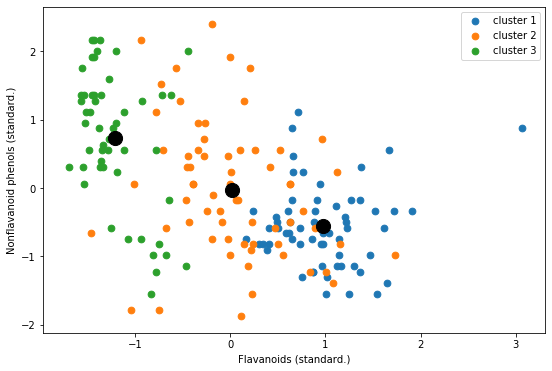

In [315]:
fig = plt.figure(figsize=(9,6))

for i in range(C.K):
    cluster = np.array(C.Cluster[i+1])
    plt.scatter(cluster[:,6], cluster[:,7], s=45, label="cluster "+str(i+1))
plt.scatter(C.C[:,6], C.C[:,7], c="black", s=200)
plt.xlabel("Flavanoids (standard.)")
plt.ylabel("Nonflavanoid phenols (standard.)")
plt.legend()
plt.show()

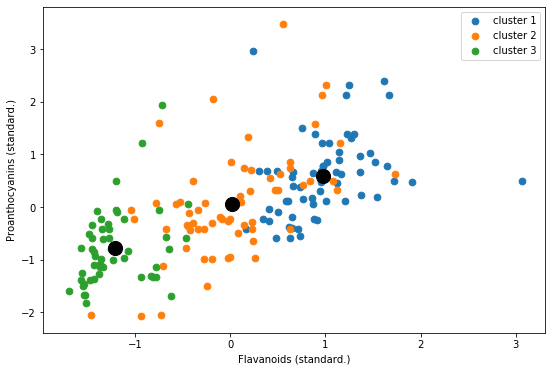

In [316]:
fig = plt.figure(figsize=(9,6))

for i in range(C.K):
    cluster = np.array(C.Cluster[i+1])
    plt.scatter(cluster[:,6], cluster[:,8], s=45, label="cluster "+str(i+1))
plt.scatter(C.C[:,6], C.C[:,8], c="black", s=200)
plt.xlabel("Flavanoids (standard.)")
plt.ylabel("Proanthocyanins (standard.)")
plt.legend()
plt.show()

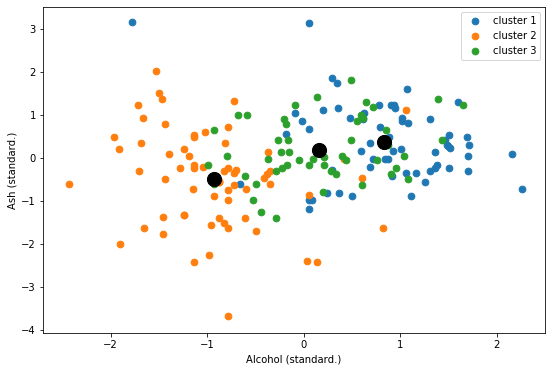

In [317]:
fig = plt.figure(figsize=(9,6))

for i in range(C.K):
    cluster = np.array(C.Cluster[i+1])
    plt.scatter(cluster[:,0], cluster[:,2], s=45, label="cluster "+str(i+1))
plt.scatter(C.C[:,0], C.C[:,2], c="black", s=200)
plt.xlabel("Alcohol (standard.)")
plt.ylabel("Ash (standard.)")
plt.legend()
plt.show()

# K-means can go wrong

We run another time the k-means algorithm code (written in a short and not commented way), only to show one case where our k-means implementation can go wrong.  
In the graph shown below, it's clear that this time k-means doesn't provide us a good classification and a valid separation among the data.  
This happens because of the strong dependence of the k-means from the initial condition: in this case, the centroids have been randomly chosen too close together and this means that, step by step, one of these two clusters will prevail over the other, leaving it with few points or worse with no point.

In [320]:
C = clust.Kmeans(3, len(features))

C.random_centers(data_matrix)
C.clustering(data_matrix)

cost_function_values = np.zeros(100)

up = 0

while (up <= 1) or (abs(cost_function_values[up-1]-cost_function_values[up-2]) > 0.1):
    cost_function_values[up] = C.cost_function()
    C.update_centers()
    C.clustering(data_matrix)
    up += 1 

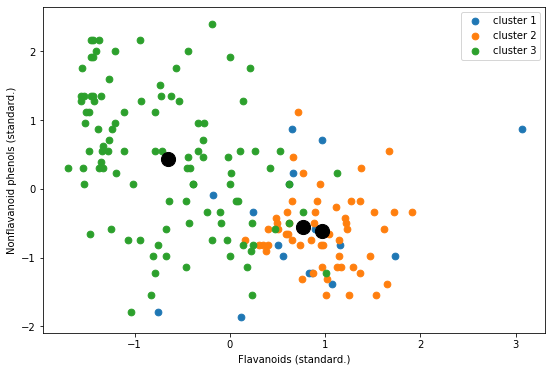

In [321]:
fig = plt.figure(figsize=(9,6))

for i in range(C.K):
    cluster = np.array(C.Cluster[i+1])
    plt.scatter(cluster[:,6], cluster[:,7], s=45, label="cluster "+str(i+1))
plt.scatter(C.C[:,6], C.C[:,7], c="black", s=200)
plt.xlabel("Flavanoids (standard.)")
plt.ylabel("Nonflavanoid phenols (standard.)")
plt.legend()
plt.show()

The __K-means algorithm__ is one of the most popular clustering algorithms however its operation is heavily influenced by the initialization, therefore a correct initialization can reduce the computational cost of the algorithm.
So to see if a better initialization works, we use k-means++ to choose the initial values (or seeds) for the k-means clustering algorithm.



In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# Import the dataset 
df = pd.read_csv("../Crime2001.csv")

C:\Users\Giulio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### We need a big DataFrame, we can use the dataframe used during the 28/11 lab with information about Chicago crimes

In [3]:
#we need only the latitude and the longitude to verify our hypothesis
col_n = ['Longitude', 'Latitude']
df = pd.DataFrame(df,columns=col_n)
#We drop the null values 
#and those smaller than 91 to avoid errors (same thing used during the lesson of the laboratory)
df = df.dropna(0)
df.drop( df[ df['Longitude'] < -91].index , inplace=True)

### In this case used the random init

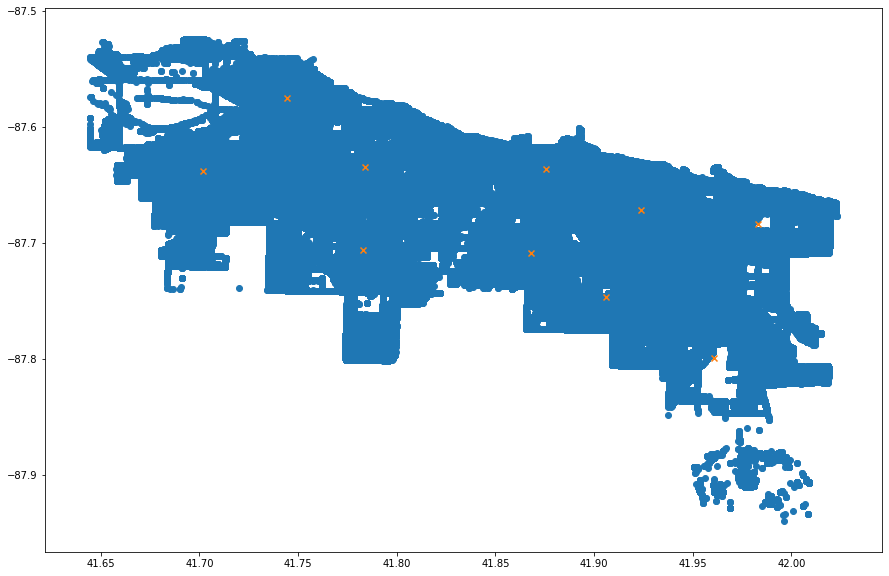

Rand time:  1109.4936373233795


In [4]:
start = time.time()

# Create our k-mean model with random init
model = KMeans(n_clusters = 10, init = 'random')

# Fit our data in the model
model.fit(df[['Latitude', 'Longitude']])

centroids = model.cluster_centers_

fig = plt.figure(figsize = (15,10))
plt.scatter(df['Latitude'],df['Longitude'])
plt.scatter(centroids[:,0], centroids[:,1], marker='x')

plt.show()

time_rand = time.time() - start
print('Rand time: ', time_rand)


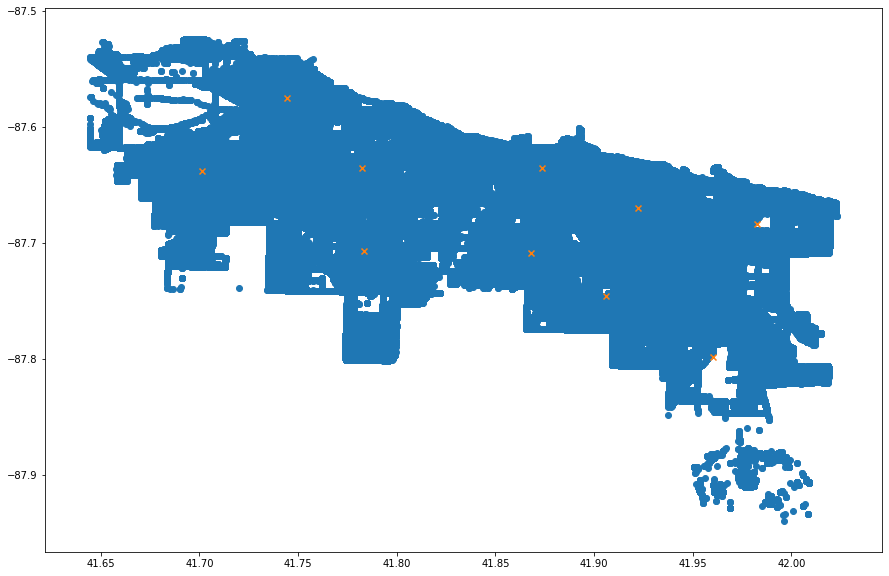

K-means++ time:  492.2247664928436


In [7]:
start = time.time()

# Create our k-mean model with k-means++ init
model1 = KMeans(n_clusters = 10, init = 'k-means++')

# Fit our data in the model
model1.fit(df[['Latitude', 'Longitude']])

centroids1 = model.cluster_centers_

fig1 = plt.figure(figsize = (15,10))
plt.scatter(df['Latitude'],df['Longitude'])
plt.scatter(centroids1[:,0], centroids1[:,1], marker='x')
plt.show()

time_k = time.time() - start
print('K-means++ time: ', time_k)

## Conclusion

Using the k-means++ we have a speedup of:

In [9]:
print(100*(1-time_k/time_rand), " %")

14.158383999815705  %
